In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import pywt
from skimage.restoration import denoise_wavelet
from scipy.stats import skew, kurtosis
import os
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,MaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/emgdata/new_dataset/eswar_new/Fist/1/10_Fist_Ultium EMG-BRACHIORAD. RT.csv')
df=df.iloc[2:,:]
df.head()


,type,name,time_units,begin_time,frequency,count,units
2,98.98000,-0.5913236975,NaN,NaN,NaN,NaN,NaN
3,98.98050,5.817758864,NaN,NaN,NaN,NaN,NaN
4,98.98100,12.22684143,NaN,NaN,NaN,NaN,NaN
5,98.98150,12.83723024,NaN,NaN,NaN,NaN,NaN
6,98.98200,4.596981233,NaN,NaN,NaN,NaN,NaN


In [ ]:
lak=df[(df['time']>=3) & (df['time']<=8.5)]

In [ ]:
np.max(lak['Brachiarod'])

1670.348058

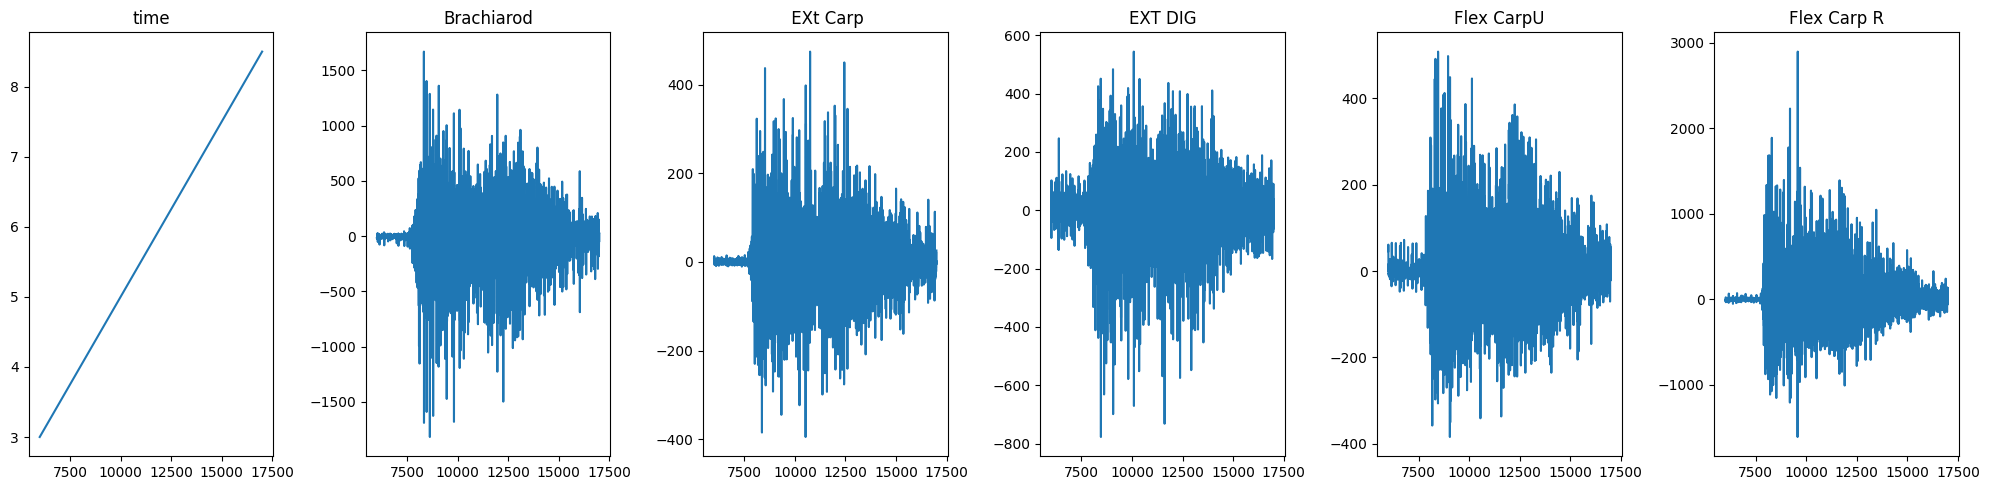

In [ ]:
import matplotlib.pyplot as plt


data = lak


columns = data.columns


fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(20, 5))


for i, column in enumerate(columns):
    axes[i].plot(data[column])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()


In [ ]:
def filtering_of_signal(df):
  cutoff_freq=50
  new=df.copy()
  order=4
  time_diff=np.array(df.iloc[-1,0]).astype(np.float64)-np.array(df.iloc[0,0]).astype(np.float64)
  fs=len(df.iloc[:,0])/time_diff
  b, a = butter(order, cutoff_freq / (fs / 2), btype='high')
  for i in range(1,df.shape[1]):
    signal = np.array(df.iloc[:,i]).astype(np.float64)
    filtered_signal = filtfilt(b, a, signal)
    x_denoise=denoise_wavelet(filtered_signal,method='BayesShrink',mode='soft',wavelet_levels=3,wavelet='sym8',rescale_sigma='True')
    new.iloc[:,i]=x_denoise
  return new

In [ ]:
def apply_window(data, window_size,samples_per_window):
    segments=[]
    for i in range(0, len(data) - samples_per_window + 1, samples_per_window):

        window_data = data.iloc[i:i+samples_per_window,:]

        segments.append(window_data)

    return segments


directory = r'/content/drive/MyDrive/emgdata/new_dataset'

processed_data = []
data_dicts=[]
target=[]
lak4=[]
for subdir in os.listdir(directory):
    subdir_path = os.path.join(directory, subdir)
    if os.path.isdir(subdir_path):

        os.chdir(subdir_path)

        for dirs in os.listdir(subdir_path):
             label = dirs
             lak=os.path.join(subdir_path,dirs)
             for lak1 in os.listdir(lak):
                  lak2=os.path.join(lak,lak1)

                  for filename in os.listdir(lak2):
                    combined_data={}

                    info = {'label': label}
                    if filename.startswith('concatenat') and filename.endswith('.csv'):
                        filepath=os.path.join(lak2,filename)
                        target.append(label)
                        df = pd.read_csv(filepath)

                        df['time'] = df['time'] - df['time'].iloc[0]

                        df = df[(df['time'] >= 3) & (df['time'] <= 8.51)]
                        df=filtering_of_signal(df)
                        df=df.drop('time',axis=1)
                        window_size = 250
                        data_dict={}
                        samples_per_window=500
                        print(samples_per_window)

                        segments=apply_window(df,window_size,samples_per_window)
                        segments=np.array(segments)
                        lak4.append(segments)





In [ ]:
lak4=np.array(lak4)
target=np.array(target)

In [ ]:
np.save('/content/drive/MyDrive/lak.npy', lak4)
np.save('/content/drive/MyDrive/target.npy',target)

In [ ]:
lak4=archive = np.load('/content/drive/MyDrive/lak.npy')
target=archive = np.load('/content/drive/MyDrive/target.npy')

In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(target)
y_one_hot = to_categorical(y_encoded,7)
input_shape = (lak4.shape[1], lak4.shape[2],lak4.shape[3])
X_train, X_test, Y_train, Y_test = train_test_split(lak4, y_one_hot, test_size=0.2, random_state=42)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(lak4, y_encoded, test_size=0.2, random_state=42)

In [ ]:
from torch.utils.data import Subset, DataLoader, SubsetRandomSampler


input_tensor = torch.tensor(lak4, dtype=torch.float32)
target_tensor = torch.tensor(target, dtype=torch.long)  # Assuming targets are integers

dataset = TensorDataset(input_tensor, target_tensor)

split_ratio = 0.8
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(split_ratio * dataset_size))

np.random.shuffle(indices)

train_indices, test_indices = indices[:split], indices[split:]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

batch_size = 16
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint


input_shape = (22, 500, 5)


model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(1, 1)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))


model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))

model.add(Dense(64,activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


checkpoint = ModelCheckpoint('/content/drive/MyDrive/model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

history=model.fit(x_train, y_train, epochs=20, batch_size=16, validation_data=(x_test, y_test), callbacks=[checkpoint])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 20, 498, 64)       2944      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 20, 498, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 18, 496, 128)      73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 18, 496, 128)      0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 494, 256)      295168    
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 16, 494, 256)     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 209s 18s/step - loss: 1.9692 - accuracy: 0.1282 - val_loss: 1.9956 - val_accuracy: 0.0500
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 1.9621 - accuracy: 0.1538 
Epoch 2: val_accuracy improved from 0.05000 to 0.07500, saving model to /content/drive/MyDrive/model.h5
10/10 [==============================] - 182s 18s/step - loss: 1.9621 - accuracy: 0.1538 - val_loss: 1.9952 - val_accuracy: 0.0750
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 1.9479 - accuracy: 0.1603 
Epoch 3: val_accuracy did not improve from 0.07500
10/10 [==============================] - 157s 15s/step - loss: 1.9479 - accuracy: 0.1603 - val_loss: 2.0158 - val_accuracy: 0.0500
Epoch 4/20
10/10 [==============================] - ETA: 0s - loss: 1.9458 - accuracy: 0.1667 
Epoch 4: val_accuracy did not improve from 0.07500
10/10 [==============================] - 182s 18s/step - loss: 1.9458 - accuracy: 0.1667 - val_loss: 1.9982 - val_ac

In [ ]:
from sklearn.metrics import confusion_matrix
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Generate predictions on test data
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Assuming you have already prepared your data and it's in torch tensors format
# Assuming x_train, y_train, x_test, y_test are torch tensors

# Define your model architecture
class ConvLSTM(nn.Module):
    def __init__(self):
        super(ConvLSTM, self).__init__()
        self.conv1 = nn.Conv2d(5, 64, kernel_size=(3, 3))
        self.maxpool = nn.MaxPool2d(kernel_size=(1, 1))
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 3))
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3, 3))
        self.flatten = nn.Flatten()
        self.lstm1 = nn.LSTM(22*256, 128, batch_first=True, dropout=0.2)
        self.lstm2 = nn.LSTM(128, 64, batch_first=True, dropout=0.2)
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 7)

    def forward(self, x):
        x = self.maxpool(torch.relu(self.conv1(x)))
        x = self.maxpool(torch.relu(self.conv2(x)))
        x = self.maxpool(torch.relu(self.conv3(x)))
        x = self.flatten(x)
        x, _ = self.lstm1(x.unsqueeze(0))
        x, _ = self.lstm2(x)
        x = torch.relu(self.fc1(x[:, -1, :]))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=-1)
        return x

# Initialize the model
model = ConvLSTM()

# Move model and data to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
x_train, y_train, x_test, y_test = x_train.to(device), y_train.to(device), x_test.to(device), y_test.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Convert data into DataLoader
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Training the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss}, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")

# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/model.pth')

In [ ]:
train_losses = []

# Assuming you have your test data ready as test_loader
# Let's say your test_loader is a DataLoader containing test samples
# Iterate over test_loader to obtain predictions
true_labels = []
predicted_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_losses.append(loss.item())
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the loss curve
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

### VGG16 architecture

In [ ]:
model1 = Sequential()
model1.add(Conv2D(input_shape=input_shape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model1.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model1.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model1.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model1.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model1.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model1.add(Flatten())
model1.add(Dense(units=128,activation="relu"))
model1.add(Dense(units=64,activation="relu"))
model1.add(Dense(units=7, activation="softmax"))
model1.summary()
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model1.summary()
checkpoint = ModelCheckpoint('/content/drive/MyDrive/model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
model1.fit(x_train, y_train, epochs=50, batch_size=16, validation_data=(x_test,y_test),callbacks=[checkpoint])

### Resnet18 architecture

In [ ]:
from torch.utils.data import Subset, DataLoader, SubsetRandomSampler


input_tensor = torch.tensor(lak4, dtype=torch.float32)
target_tensor = torch.tensor(target, dtype=torch.long)  # Assuming targets are integers

dataset = TensorDataset(input_tensor, target_tensor)

split_ratio = 0.8
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(split_ratio * dataset_size))

np.random.shuffle(indices)

train_indices, test_indices = indices[:split], indices[split:]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

batch_size = 16
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
class ResNet18Custom(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18Custom, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        # Modify the input layer to accept 5-channel input
        self.resnet18.conv1 = nn.Conv2d(5, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Modify the output layer to match the number of classes
        self.resnet18.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        return self.resnet18(x)

# Create an instance of ResNet18Custom
num_classes = 7
resnet_custom = ResNet18Custom(num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_custom.parameters(), lr=0.001, momentum=0.9)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = resnet_custom(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

# Test the model
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = resnet_custom(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))